In [114]:
import nltk
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer

from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Download required NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

df = pd.read_csv('data/IMDB Dataset.csv')
# Set of English stop words
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


# Function to clean text data
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"\'", " ", text)  # Remove apostrophes
    text = re.sub(r"[^\w\s]", " ", text)  # Remove punctuation
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if len(word) > 2])  # Lemmatize and remove short words
    text = re.sub(r"<.*?>", "", text)  # Remove HTML tags
    return text

# Assuming df is your DataFrame containing reviews and sentiment labels
df["review"] = df["review"].astype(str)
df["review"] = df["review"].apply(clean_text)

# Tokenize the reviews
tokenized_reviews = df["review"].apply(nltk.word_tokenize)
df["tokenized_reviews"] = tokenized_reviews

# Tokenizer and sequence padding
tokenizer = Tokenizer(num_words=5000)  # Limit the vocabulary size
tokenizer.fit_on_texts(tokenized_reviews)
sequences = tokenizer.texts_to_sequences(tokenized_reviews)
X = pad_sequences(sequences, maxlen=500)

# Label encoding
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["sentiment"])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True)

# Early stopping and learning rate decay
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-5)

# Build LSTM model
vocab_size = min(tokenizer.num_words, len(tokenizer.word_index)) + 1  # Use num_words from tokenizer
print(vocab_size)

model_lstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=500),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model
model_lstm.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, callbacks=[early_stopping, reduce_lr])





[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/camille/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/camille/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/camille/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/camille/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


5001
Epoch 1/10


/Users/camille/miniconda3/envs/keras-jax/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 203s 160ms/step - accuracy: 0.7947 - loss: 0.4348 - val_accuracy: 0.8573 - val_loss: 0.3359 - learning_rate: 0.0010
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 190s 152ms/step - accuracy: 0.8953 - loss: 0.2702 - val_accuracy: 0.8806 - val_loss: 0.2944 - learning_rate: 0.0010
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 178s 143ms/step - accuracy: 0.9229 - loss: 0.2073 - val_accuracy: 0.8810 - val_loss: 0.3038 - learning_rate: 0.0010
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 171s 136ms/step - accuracy: 0.9404 - loss: 0.1648 - val_accuracy: 0.8830 - val_loss: 0.3087 - learning_rate: 0.0010
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 177s 141ms/step - accuracy: 0.9530 - loss: 0.1354 - val_accuracy: 0.8711 - val_loss: 0.3451 - learning_rate: 0.0010
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 164s 131ms/step - accuracy: 0.9751 - loss: 0.0861 - val_accuracy: 0.8730 - val_loss: 0.4207 - learning_rate: 1.0000e-04
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 158s 127ms/step -

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step


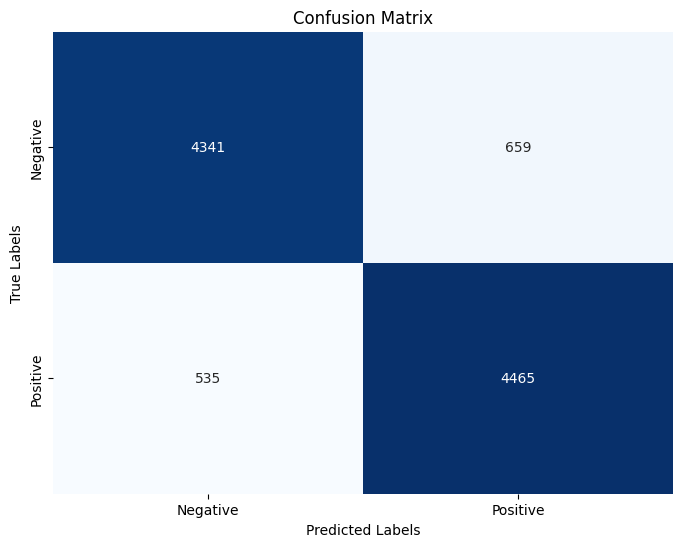

In [117]:
# Generate predictions
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred_prob = model_lstm.predict(X_test)
y_pred_classes = (y_pred_prob > 0.5).astype("int32")

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Accuracy: 0.8806
Precision: 0.8713895394223263
Recall: 0.893
F1-score: 0.8820624259186093
Sensitivity: 0.5124
Specificity: 0.4876


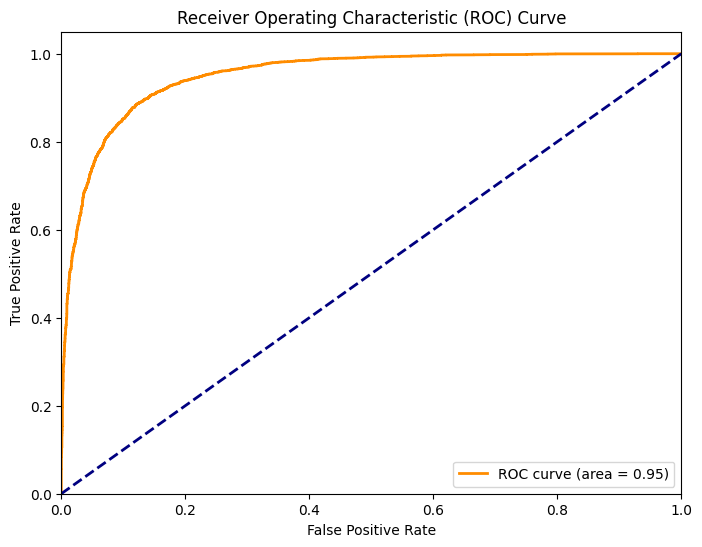

In [118]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

# Accuracy
accuracy = accuracy_score(y_test, y_pred_classes)

# Precision
precision = precision_score(y_test, y_pred_classes)

# Recall
recall = recall_score(y_test, y_pred_classes)

# F1-score
f1 = f1_score(y_test, y_pred_classes)

# True Positives, True Negatives, False Positives, False Negatives
tp = np.sum((y_test == 1) & (y_pred_classes == 1))
tn = np.sum((y_test == 0) & (y_pred_classes == 0))
fp = np.sum((y_test == 0) & (y_pred_classes == 1))
fn = np.sum((y_test == 1) & (y_pred_classes == 0))

# Sensitivity (True Positive Rate)
sensitivity = tp / (tp + fn)

# Specificity (True Negative Rate)
specificity = tn / (tn + fp)

# Print performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


### With others parameters

Gives bad results 

```python
model_lstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=500),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model
model_lstm.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, callbacks=[early_stopping, reduce_lr]
```

In [119]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

# Define your model
model_lstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=500),
    LSTM(128),
    Dropout(0.2),
    Dense(64, activation='relu'),  # Additional dense layer after LSTM
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model
model_lstm.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, callbacks=[early_stopping, reduce_lr])


Epoch 1/10


/Users/camille/miniconda3/envs/keras-jax/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 150s 118ms/step - accuracy: 0.7849 - loss: 0.4385 - val_accuracy: 0.8755 - val_loss: 0.3070 - learning_rate: 0.0010
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 126s 101ms/step - accuracy: 0.9056 - loss: 0.2436 - val_accuracy: 0.8829 - val_loss: 0.2812 - learning_rate: 0.0010
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 119s 95ms/step - accuracy: 0.9219 - loss: 0.2030 - val_accuracy: 0.8750 - val_loss: 0.3026 - learning_rate: 0.0010
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 115s 92ms/step - accuracy: 0.9374 - loss: 0.1687 - val_accuracy: 0.8748 - val_loss: 0.3135 - learning_rate: 0.0010
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 112s 89ms/step - accuracy: 0.9608 - loss: 0.1116 - val_accuracy: 0.8776 - val_loss: 0.4082 - learning_rate: 2.0000e-04


313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step


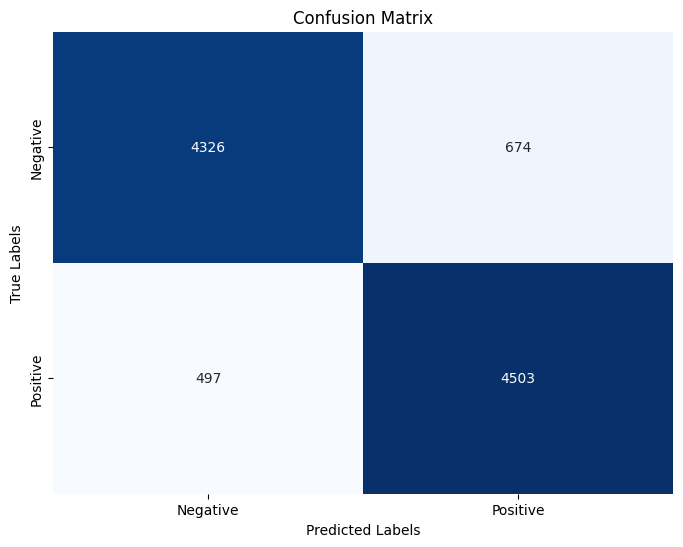

Accuracy: 0.8829
Precision: 0.8698087695576588
Recall: 0.9006
F1-score: 0.8849366217942419
Sensitivity: 0.5177
Specificity: 0.4823


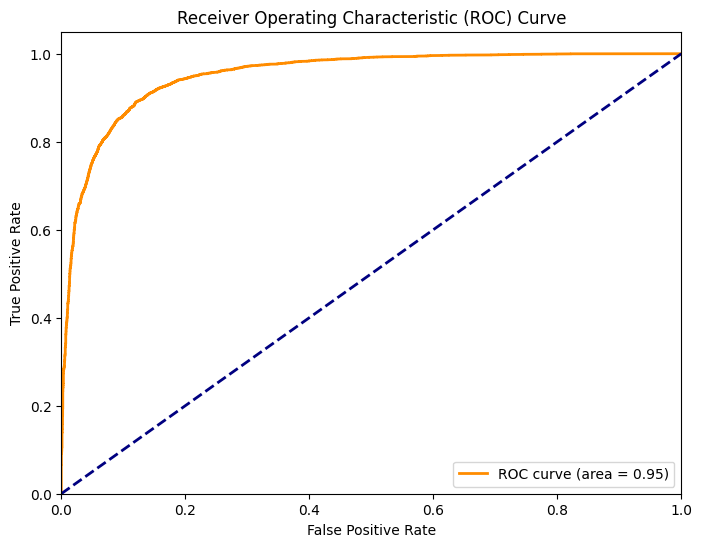

AUC: 0.95145012


In [120]:
# Generate predictions
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred_prob = model_lstm.predict(X_test)
y_pred_classes = (y_pred_prob > 0.5).astype("int32")

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

# Accuracy
accuracy = accuracy_score(y_test, y_pred_classes)

# Precision
precision = precision_score(y_test, y_pred_classes)

# Recall
recall = recall_score(y_test, y_pred_classes)

# F1-score
f1 = f1_score(y_test, y_pred_classes)

# True Positives, True Negatives, False Positives, False Negatives
tp = np.sum((y_test == 1) & (y_pred_classes == 1))
tn = np.sum((y_test == 0) & (y_pred_classes == 0))
fp = np.sum((y_test == 0) & (y_pred_classes == 1))
fn = np.sum((y_test == 1) & (y_pred_classes == 0))

# Sensitivity (True Positive Rate)
sensitivity = tp / (tp + fn)

# Specificity (True Negative Rate)
specificity = tn / (tn + fp)

# Print performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print("AUC:", roc_auc)


# Ask me 


In [121]:
def preprocess_sentence(sentence):
    # Clean the input sentence
    cleaned_sentence = clean_text(sentence)
    # Tokenize the sentence
    tokenized_sentence = nltk.word_tokenize(cleaned_sentence)
    # Convert tokens to sequences
    sequence = tokenizer.texts_to_sequences([tokenized_sentence])
    # Pad the sequence
    padded_sequence = pad_sequences(sequence, maxlen=500)
    return padded_sequence

def predict_sentiment(model, sentence):
    # Preprocess the input sentence
    preprocessed_sentence = preprocess_sentence(sentence)
    # Make prediction
    prediction = model.predict(preprocessed_sentence)
    # Convert prediction to class
    predicted_class = "Positive" if prediction > 0.5 else "Negative"
    return predicted_class

# Example usage:
sentence = "Very bad movie! Waste of time."
predicted_class = predict_sentiment(model_lstm, sentence)
print("Predicted sentiment:", predicted_class)
print("Predicted probability:", model_lstm.predict(preprocess_sentence(sentence))[0][0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Predicted sentiment: Negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted probability: 0.018357467


### Save the model

In [21]:
# Define the file path to save the model
model_file_path = "model_lstm.h5"

# Save the model
model_lstm.save(model_file_path)

print("Model saved successfully.")


Model saved successfully.


##  LTSM with attention


In [3]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Attention

# Download required NLTK data
nltk.download('stopwords')
nltk.download('punkt')

# Read the data
df = pd.read_csv('data/IMDB Dataset.csv')

# Set of English stop words
stop_words = set(stopwords.words('english'))

# Function to clean text data
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"\'", " ", text)  # Remove apostrophes
    text = re.sub(r"[^\w\s]", " ", text)  # Remove punctuation
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    text = ' '.join([w for w in text.split() if len(w) > 2])  # Remove short words
    text = re.sub(r"<.*?>", "", text)  # Remove HTML tags
    return text

# Clean the text data
df["review"] = df["review"].astype(str)
df["review"] = df["review"].apply(clean_text)

# Tokenize the reviews
tokenizer = Tokenizer(num_words=5000)  # Limit the vocabulary size
tokenizer.fit_on_texts(df["review"])
sequences = tokenizer.texts_to_sequences(df["review"])
X = pad_sequences(sequences, maxlen=100)

# Label encoding
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["sentiment"])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True)

# Define the model
input_layer = Input(shape=(100,))
embedding_layer = Embedding(input_dim=5000, output_dim=128)(input_layer)
lstm_layer = LSTM(128, return_sequences=True)(embedding_layer)
attention_layer = Attention()([lstm_layer, lstm_layer])
output_layer = Dense(1, activation='sigmoid')(attention_layer)

# Create the model
model_lstm_attention = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model_lstm_attention.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display model summary
model_lstm_attention.summary()

from tensorflow.keras.layers import Flatten

# Define the model
input_layer = Input(shape=(100,))
embedding_layer = Embedding(input_dim=5000, output_dim=128)(input_layer)
lstm_layer = LSTM(200, return_sequences=True)(embedding_layer)

attention_layer = Attention()([lstm_layer, lstm_layer])
flatten_layer = Flatten()(attention_layer)
output_layer = Dense(1, activation='sigmoid')(flatten_layer)

# Create the model
model_lstm_attention = Model(inputs=input_layer, outputs=output_layer)
# Compile the model
model_lstm_attention.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
history = model_lstm_attention.fit(X_train, y_train, 
                                   epochs=20, 
                                   batch_size=64, 
                                   validation_data=(X_test, y_test), 
                                   callbacks=[EarlyStopping(patience=6, monitor='val_loss'), 
                                              ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=6)])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/camille/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/camille/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
2024-06-12 16:02:29.124060: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-06-12 16:02:29.124091: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-06-12 16:02:29.124111: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-06-12 16:02:29.124135: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-12 16:02:29.124152: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memo

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 128)  │    640,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 100, 128)  │    131,584 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 100, 128)  │          0 │ lstm[0][0],       │
│ (Attention)         │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 100, 1)    │        129 │ attention[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 771,713 (2.94 MB)

 Trainable params: 771,713 (2.94 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


2024-06-12 16:02:29.895039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 43ms/step - accuracy: 0.7862 - loss: 0.4303 - val_accuracy: 0.8822 - val_loss: 0.2785 - learning_rate: 0.0010
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step - accuracy: 0.9076 - loss: 0.2322 - val_accuracy: 0.8808 - val_loss: 0.2819 - learning_rate: 0.0010
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 41ms/step - accuracy: 0.9279 - loss: 0.1828 - val_accuracy: 0.8779 - val_loss: 0.2988 - learning_rate: 0.0010
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 41ms/step - accuracy: 0.9472 - loss: 0.1402 - val_accuracy: 0.8746 - val_loss: 0.3611 - learning_rate: 0.0010
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.9634 - loss: 0.0987 - val_accuracy: 0.8650 - val_loss: 0.4918 - learning_rate: 0.0010
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - accuracy: 0.9774 - loss: 0.0608 - val_accuracy: 0.8620 - val_loss: 0.5419 - learning_rate: 0.0010
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.9846 - loss: 0.0446

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step


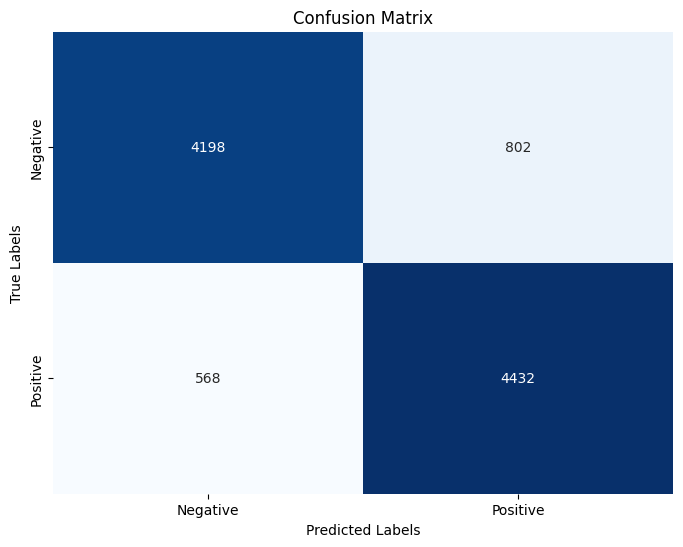

In [4]:
# Generate predictions
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred_prob = model_lstm_attention.predict(X_test)
y_pred_classes = (y_pred_prob > 0.5).astype("int32")
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Accuracy: 0.863
Precision: 0.8467711119602599
Recall: 0.8864
F1-score: 0.8661324995114325
Sensitivity: 0.5234
Specificity: 0.4766


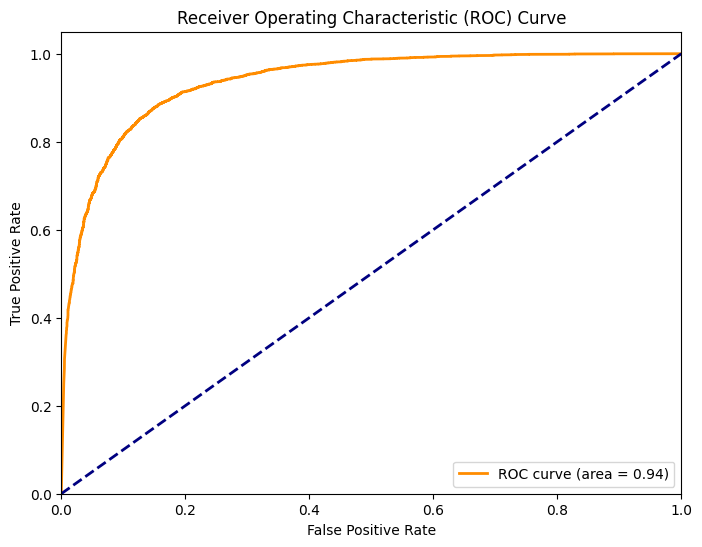

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
tp = np.sum((y_test == 1) & (y_pred_classes == 1))
tn = np.sum((y_test == 0) & (y_pred_classes == 0))
fp = np.sum((y_test == 0) & (y_pred_classes == 1))
fn = np.sum((y_test == 1) & (y_pred_classes == 0))
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


# Use transformers


In [ ]:
!pip install transformers

In [62]:
!pip install tf-keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 14.2 MB/s eta 0:00:0000:0100:01


In [63]:
from transformers import TFBertForSequenceClassification, BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model_transformer = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')



/Users/camille/miniconda3/envs/keras-jax/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
